In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from config_ursse import get_from_config
import os
from scipy.optimize import curve_fit
import struct
from datetime import datetime
import time

In [249]:
now = datetime.now()
stamp = time.mktime(now.timetuple())
print(stamp)

1625185089.0


In [284]:
now.timestamp()

1625185089.530198

In [173]:
path = "/Users/ilobach/OneDrive - Fermi National Accelerator Laboratory/URSSE/for_Valeri_long_memory_scope"
file_path = os.path.join(path, "RefCurve_2021-07-02_1_003234.Wfm.bin")
file_path

'/Users/ilobach/OneDrive - Fermi National Accelerator Laboratory/URSSE/for_Valeri_long_memory_scope/RefCurve_2021-07-02_1_003234.Wfm.bin'

In [174]:
n = 1000

In [285]:
timestamps = []
ch1 = []
ch2 = []
with open(file_path, 'rb') as f:
    f.read(8)
    for _ in range(100000):
        t = np.frombuffer(f.read(8), np.uint64)[0]
        timestamps.append(t)
        wf = np.frombuffer(f.read(4*2*n), np.float32)
        ch1.append(wf[::2])
        ch2.append(wf[1::2])
timestamps = np.array(timestamps)
ch1 = np.array(ch1)
ch2 = np.array(ch2)

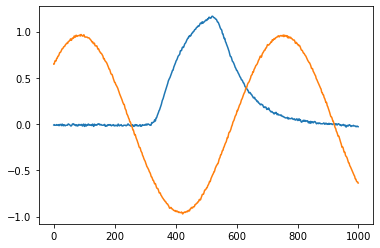

In [286]:
plt.plot(ch1[0])
plt.plot(ch2[0])

In [297]:
timestamps[:100]

array([13843338135297340065, 13843338012534505073, 13843337932117614400,
       13843337890095307810, 13843337853961701824, 13843337759946375914,
       13843337729431015522, 13843337557506930978, 13843337416168993385,
       13843337402507105112, 13843337359497388922, 13843337253932342075,
       13843337210436121236, 13843337101954647064, 13843337080319021962,
       13843336994081287484, 13843336964239141569, 13843336916794195143,
       13843336778608642050, 13843336554453625420, 13843336528473673966,
       13843336315685355329, 13843336253615118207, 13843336207683546403,
       13843336201217871794, 13843336193299134515, 13843336156507108861,
       13843336144447446305, 13843336044996411325, 13843336023795859895,
       13843335916999298012, 13843335854777992171, 13843335829911025100,
       13843335782593485244, 13843335719960141818, 13843335647077830497,
       13843335597687079223, 13843335478988140802, 13843335350746262127,
       13843335291738259227, 13843335239388945584, 

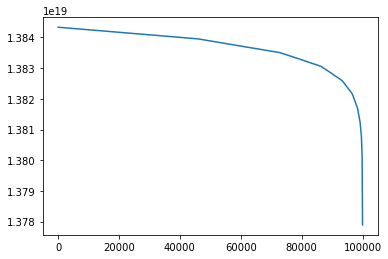

In [306]:
plt.plot(timestamps[:-1])

In [201]:
# n = 1000
# ch1 = chan1.reshape(-1, n)
# ch2 = chan2.reshape(-1,n)

In [202]:
# plt.plot(chan1[:3 * n])
# plt.plot(chan2[:3 * n])
# plt.ylim(-1,1)

In [190]:
dt = 0.05 #ns
f0 = 0.030 # GHz

In [191]:
t = dt * np.arange(n)
# check that the rf frequency is as expected
def func(x, A, B, f):
    return A * np.cos(2 * np.pi * f * x) + B * np.sin(2 * np.pi * f * x)

popt, pcov = curve_fit(func, t, ch2[0], p0=[0, 1,f0])
popt

array([0.65282808, 0.69840374, 0.03001398])

In [192]:
X = np.vstack([np.cos(2 * np.pi * f0 * t), np.sin(2 * np.pi * f0 * t)]).T
y = ch2[0]
res = np.linalg.lstsq(X, y, rcond=None)
Afit, Bfit = res[0]

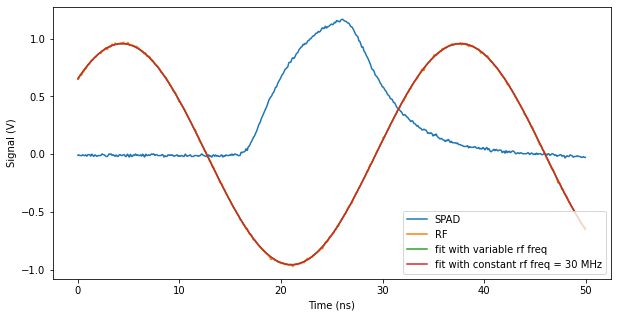

In [193]:
fig, ax = plt.subplots(figsize=(10, 5))
t = dt * np.arange(n)
ax.plot(t, ch1[0], label='SPAD')
ax.plot(t, ch2[0], label='RF')
ax.plot(t, func(t, *popt), label="fit with variable rf freq")
ax.plot(t, func(t, Afit, Bfit, f0), label="fit with constant rf freq = 30 MHz")
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Signal (V)')
ax.legend()
plt.show()

In [308]:
phases = []
for y in ch2:
    res = np.linalg.lstsq(X, y, rcond=None)
    Afit, Bfit = res[0]
    phases.append(np.angle(Afit + 1j * Bfit))
phases = np.array(phases)

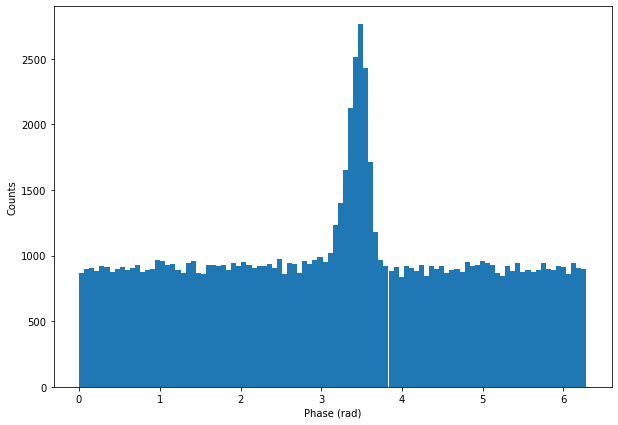

In [314]:
shift = np.pi
fig, ax = plt.subplots(figsize=(10,7))
ax.hist(((phases + np.pi) + shift) % (2*np.pi), bins=100)
ax.set_xlabel("Phase (rad)")
ax.set_ylabel("Counts")
plt.show()